<a href="https://colab.research.google.com/github/geraldsng/CreditCardFraudDetection/blob/main/Credit_Card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project for CET023 - AI and Analytics in Finance, Credit and Related Risks<br>
This final project is done based on the data source from Kaggle as indicated below.<br>
Dataset source: https://www.kaggle.com/datasets/dhanushnarayananr/credit-card-fraud

## Import Packages

In [ ]:
!pip install missingno

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats import kurtosis
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, \
accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.callbacks import EarlyStopping
import itertools

## Import Datasets

In [ ]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Google link for csv dataset
link = 'https://drive.google.com/file/d/1CCn7lVB2PyDHoli413B2Gmlu973M15jF/view?usp=sharing'

# Names to be used for dataframes
file_name = 'card_transdata'

In [ ]:
def read_data(link, file_name):
  """
  Takes in a Google link to a csv dataset and file name of corresponding csv
  Returns a pandas dataframe
  """
  id = link.split("/")[-2]
 
  downloaded = drive.CreateFile({'id':id})
  # Download into colab
  downloaded.GetContentFile(file_name + '.csv') 
  df = pd.read_csv(file_name + '.csv')

In [ ]:
read_data(link, file_name)

In [ ]:
df = pd.read_csv(r'./{}.csv'.format(file_name))

## Exploratory Data Analysis

Visualize the number of NaN values

No of NaN in each column:
 distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64


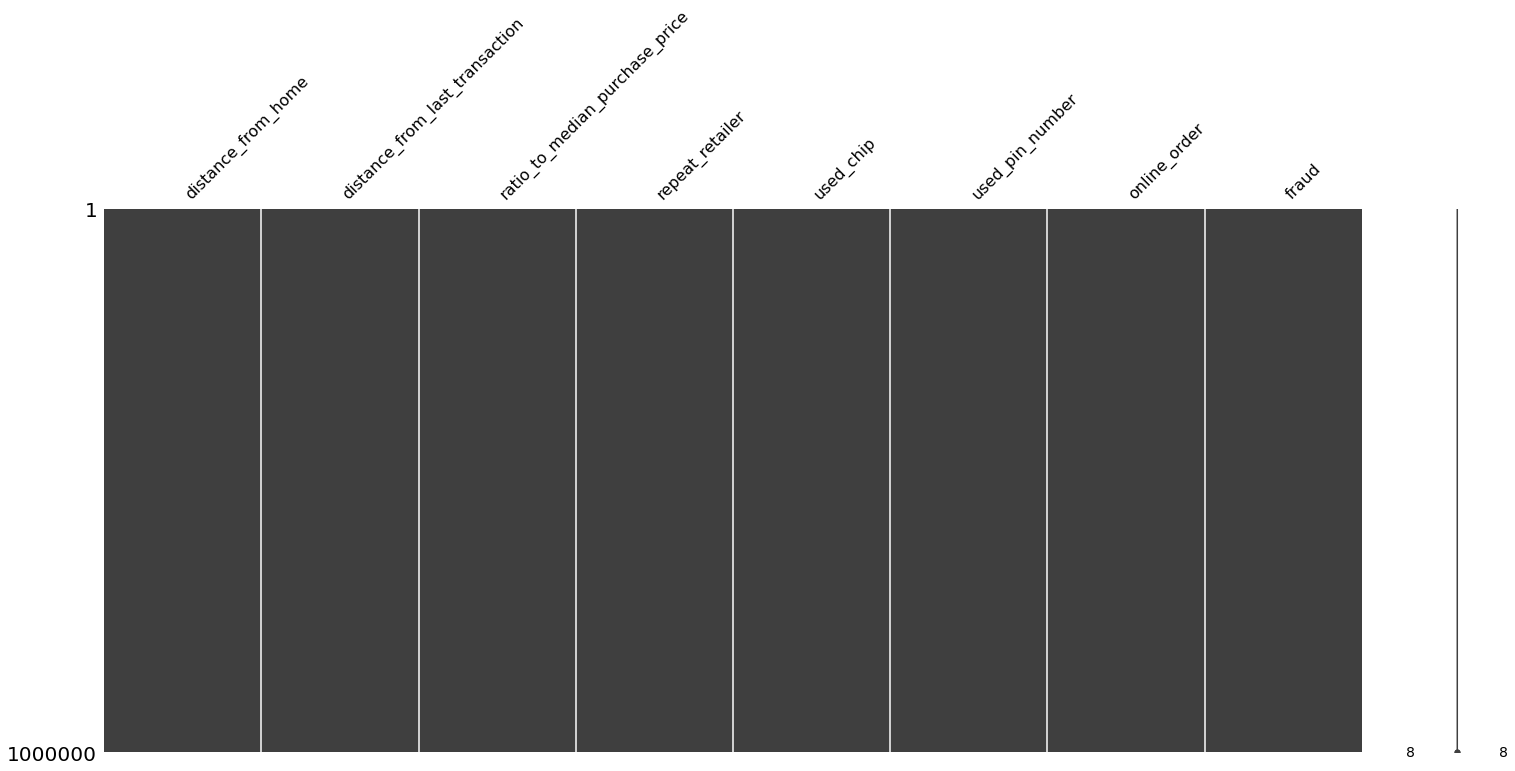

In [ ]:
print('No of NaN in each column:\n', df.isna().sum())
msno.matrix(df)

# Save image
plt.savefig('msno.png', bbox_inches='tight')

There is no Null values present in the dataset thus data imputation is not required.

In [ ]:
df.dtypes

distance_from_home                float64
distance_from_last_transaction    float64
ratio_to_median_purchase_price    float64
repeat_retailer                   float64
used_chip                         float64
used_pin_number                   float64
online_order                      float64
fraud                             float64
dtype: object

The data types of each column in the dataframe seems to be correct based on its description.

In [ ]:
df.duplicated().sum()

0

There are no duplicated data found, thus data deduplication is not required.

In [ ]:
df.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# # Save Summary statistics as png
# from pandas.plotting import table 
# ax = plt.subplot(111, frame_on=False) # no visible frame
# ax.xaxis.set_visible(False)  # hide the x axis
# ax.yaxis.set_visible(False)  # hide the y axis
# table(ax, df.describe())  # where df is your data frame
# plt.savefig('summarystats.png', bbox_inches='tight')

From the summary statistics, it looks like distance_from_home, distance_from_last_transaction and ratio_to_medium_purchase_price is highly skewed. We will verify this in the next section by checking the skewness values of the data.

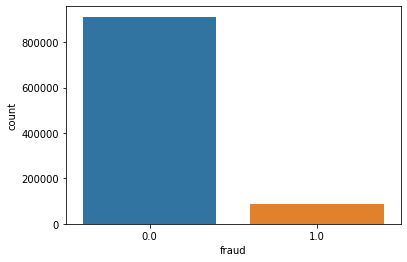

In [ ]:
sns.countplot(data = df, x = 'fraud')

From the summary statistic, it looks like the dataset is imbalanced with much lesser fraud transactions(8.7%). Therefore, it is likely that techniques such as SMOTE will be required.

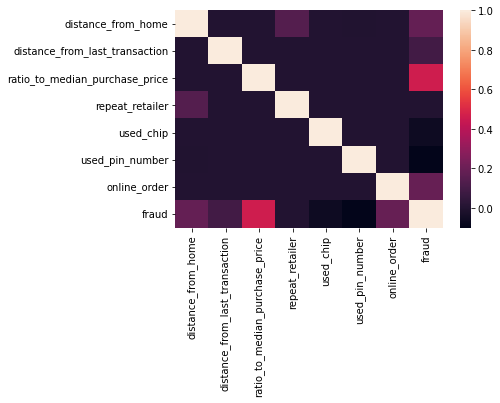

In [ ]:
sns.heatmap(df.corr())
plt.savefig('correlation_plot.png', bbox_inches='tight')

It looks like ratio_to_median_purchase_price is the only feature with the strongest correlation to fraud. There are no features which exhibit collinearity. Here we also do feature selection, and we drop the 2 features with lowest correlation: used_chip and repeat_retailer.

In [ ]:
cols = ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']

for col in cols:
  print('The skewness for {} is:'.format(col), skew(df[col].values))

for col in cols:
  print('The kurtosis for {} is:'.format(col), kurtosis(df[col].values))

The skewness for distance_from_home is: 20.23970273570892
The skewness for distance_from_last_transaction is: 125.92103696581798
The skewness for ratio_to_median_purchase_price is: 8.915001725966595
The kurtosis for distance_from_home is: 1471.6082898457348
The kurtosis for distance_from_last_transaction is: 46979.03682617058
The kurtosis for ratio_to_median_purchase_price is: 289.5018534722941


We can confirm that the 3 labels above are highly skewed since for normally distributed data, the skewness should be about zero.

Visualize the distribution of Distance from home(on a log scale)

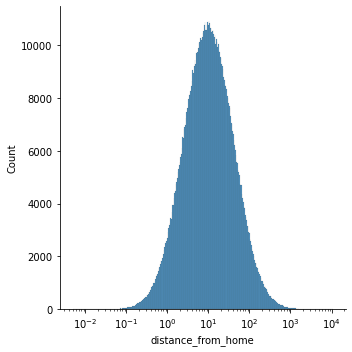

In [ ]:
sns.displot(data = df, x = 'distance_from_home', log_scale = True)

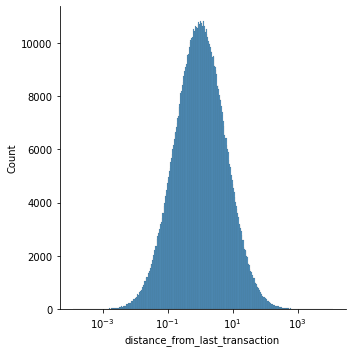

In [ ]:
sns.displot(data=df, x='distance_from_last_transaction', log_scale=True)

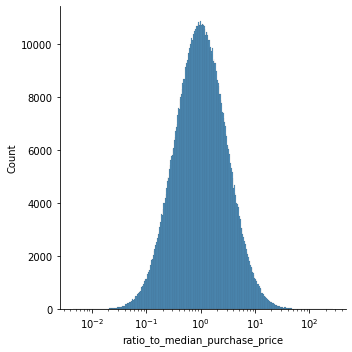

In [ ]:
sns.displot(data=df, x='ratio_to_median_purchase_price', log_scale = True)

The distribution is more Gaussian-like after using a logarithmic scale on the x-axis. We will do a logarithm transformation for preprocessing.

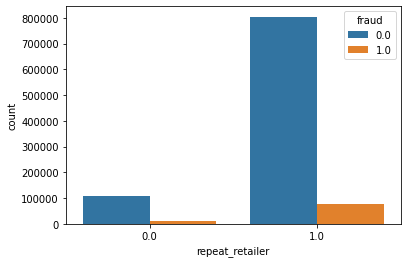

In [ ]:
sns.countplot(data=df, x='repeat_retailer', hue='fraud')

In [ ]:
# # Make a nice plot for report
# x,y = 'repeat_retailer', 'fraud'

# df1 = df.groupby(x)[y].value_counts(normalize=True)
# df1 = df1.mul(100)
# df1 = df1.rename('Percentage').reset_index()

# g = sns.catplot(x=x,y='Percentage',hue=y,kind='bar',data=df1)
# g.ax.set_ylim(0,100)

# for p in g.ax.patches:
#     txt = str(p.get_height().round(2)) + '%'
#     txt_x = p.get_x() 
#     txt_y = p.get_height()
#     g.ax.text(txt_x,txt_y,txt)

# plt.savefig('repeat_retailer.png')

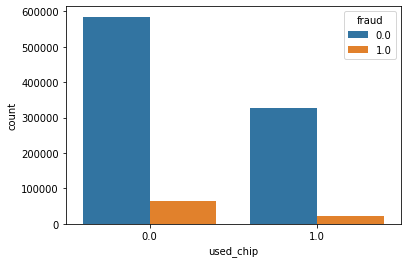

In [ ]:
sns.countplot(data=df, x='used_chip', hue='fraud')

In [ ]:
# # Make a nice plot for report
# x,y = 'used_chip', 'fraud'

# df1 = df.groupby(x)[y].value_counts(normalize=True)
# df1 = df1.mul(100)
# df1 = df1.rename('Percentage').reset_index()

# g = sns.catplot(x=x,y='Percentage',hue=y,kind='bar',data=df1)
# g.ax.set_ylim(0,100)

# for p in g.ax.patches:
#     txt = str(p.get_height().round(2)) + '%'
#     txt_x = p.get_x() 
#     txt_y = p.get_height()
#     g.ax.text(txt_x,txt_y,txt)

# plt.savefig('used_chip.png')

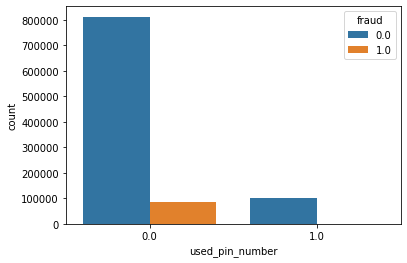

In [ ]:
sns.countplot(data=df, x='used_pin_number', hue='fraud')

In [ ]:
# # Make a nice plot for report
# x,y = 'used_pin_number', 'fraud'

# df1 = df.groupby(x)[y].value_counts(normalize=True)
# df1 = df1.mul(100)
# df1 = df1.rename('Percentage').reset_index()

# g = sns.catplot(x=x,y='Percentage',hue=y,kind='bar',data=df1)
# g.ax.set_ylim(0,100)

# for p in g.ax.patches:
#     txt = str(p.get_height().round(2)) + '%'
#     txt_x = p.get_x() 
#     txt_y = p.get_height()
#     g.ax.text(txt_x,txt_y,txt)

# plt.savefig('used_pin_number.png')

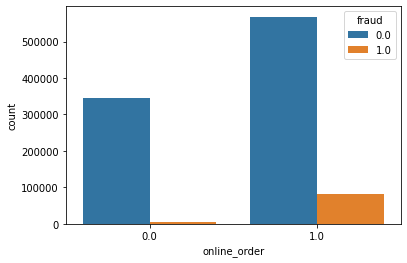

In [ ]:
sns.countplot(data = df, x = 'online_order', hue='fraud')

In [ ]:
# # Make a nice plot for report
# x,y = 'online_order', 'fraud'

# df1 = df.groupby(x)[y].value_counts(normalize=True)
# df1 = df1.mul(100)
# df1 = df1.rename('Percentage').reset_index()

# g = sns.catplot(x=x,y='Percentage',hue=y,kind='bar',data=df1)
# g.ax.set_ylim(0,100)

# for p in g.ax.patches:
#     txt = str(p.get_height().round(2)) + '%'
#     txt_x = p.get_x() 
#     txt_y = p.get_height()
#     g.ax.text(txt_x,txt_y,txt)

# plt.savefig('online_order.png')

## Data Preprocessing

In [ ]:
def preprocessing(df):
  
  df_copy = df.copy()

  cols = ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']

  for col in cols:
    pt = PowerTransformer()
    pt.fit(df[[col]])
    df_copy[col] = pt.transform(df[[col]])
  return df_copy

In [ ]:
df_preproc = preprocessing(df)

In [ ]:
X = df.drop(labels = ['fraud', 'used_chip', 'repeat_retailer'], axis = 1)
y = df['fraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 7)

In [ ]:
X_pp = df_preproc.drop(labels = ['fraud', 'used_chip', 'repeat_retailer'], axis = 1)
y_pp = df_preproc['fraud']
X_pptrain, X_pptest, y_pptrain, y_pptest = train_test_split(X_pp, y_pp, random_state = 7)

## Model Training

In [ ]:
# Metrics used for comparison and append to table
def append_metrics_to_table(table, model_name, y_pred, y_test):
  table_to_concat = pd.DataFrame({'Model': model_name,
                                  'Accuracy': accuracy_score(y_pred, y_test),
                                  'AUROC': roc_auc_score(y_pred, y_test),
                                  'Precision': precision_score(y_pred, y_test),
                                  'Recall': recall_score(y_pred, y_test)
                                }, index=[0])
  return pd.concat([table, table_to_concat], ignore_index = True)

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title='', labels=[0,1]):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title(title)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          plt.text(j, i, format(cm[i, j], fmt),
                  horizontalalignment="center",
                  color="black" if cm[i, j] > thresh else "white")
    plt.show()

In [ ]:
# Initialize the table for comparison
column_names = ['Model', 'Accuracy', 'AUROC', 'Precision', 'Recall']
table = pd.DataFrame(columns = column_names)

### Guessing all transactions as non-fraud

In [ ]:
# Predict every transaction as non-fraud
y_pred = pd.Series(data = np.zeros(len(y_test)))
print('The accuracy score by just predicting every transaction as non-fraud is {}'\
      .format(accuracy_score(y_pred, y_test)))

The accuracy score by just predicting every transaction as non-fraud is 0.913048


### Log Reg for baseline

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [ ]:
# Append metrics to table
table = append_metrics_to_table(table, 'Logreg without preproc', y_pred, y_test)

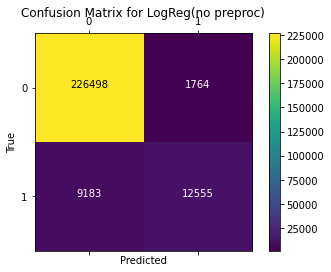

In [ ]:
plot_confusion_matrix(y_test, y_pred, title='Confusion Matrix for LogReg(no preproc)', labels=[0,1])

#### Logistic regression with preprocessing

In [ ]:
lr = LogisticRegression()
lr.fit(X_pptrain, y_pptrain)
y_pred = lr.predict(X_pptest)

In [ ]:
# # Append metrics to table
# table = append_metrics_to_table(table, 'Logreg with preprocessing', y_pred, y_test)

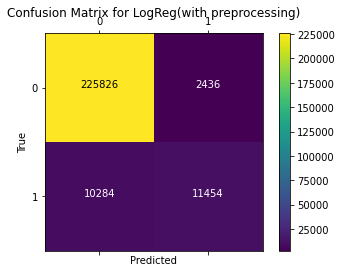

In [ ]:
plot_confusion_matrix(y_test, y_pred, title='Confusion Matrix for LogReg(with preprocessing)', labels=[0,1])

In [ ]:
table

,Model,Accuracy,AUROC,Precision,Recall
0,Logreg without preproc,0.956212,0.918922,0.57756,0.876807


It looks like preprocessing the numeric labels with Powertransformer to make it Gaussian does not help with the accuracy of prediction. Thus we will proceed with not using the preprocessed variables.

## Decision Tree

In [ ]:
dt = DecisionTreeClassifier(random_state=7, min_weight_fraction_leaf=0.05)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

In [ ]:
# Append metrics to table
table = append_metrics_to_table(table, 'Decision Tree', y_pred, y_test)

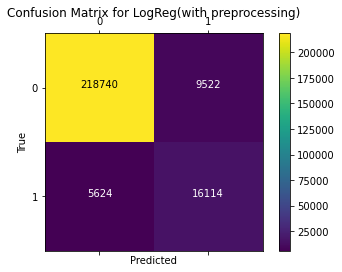

In [ ]:
plot_confusion_matrix(y_test, y_pred, title='Confusion Matrix for LogReg(with preprocessing)', labels=[0,1])


#### Feature Importance Plot

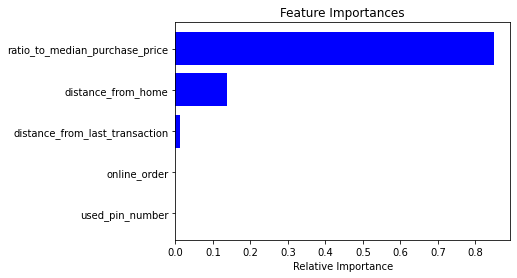

In [ ]:
features = X_train.columns
importances = dt.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### RandomForestClassifier

In [ ]:
clf = RandomForestClassifier(random_state=7)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


In [ ]:
# Append metrics to table
table = append_metrics_to_table(table, 'RandomForestClassifier', y_pred, y_test)

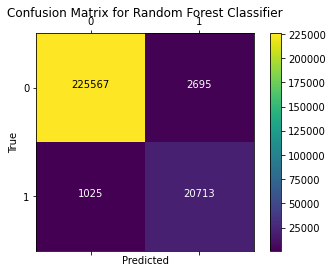

In [ ]:
plot_confusion_matrix(y_test, y_pred, title='Confusion Matrix for Random Forest Classifier', labels=[0,1])

#### Feature Importance Plot

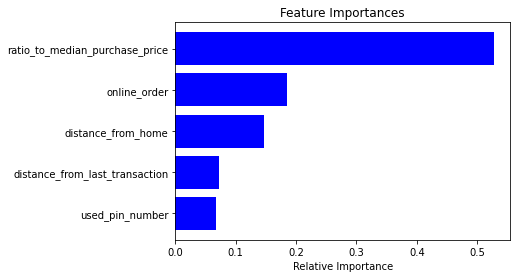

In [ ]:
features = X_train.columns
importances = clf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### XGBoost

In [ ]:
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)

In [ ]:
# Append metrics to table
table = append_metrics_to_table(table, 'XGBoost Classifier', y_pred, y_test)

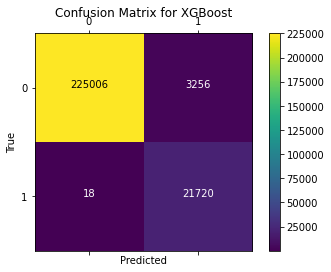

In [ ]:
plot_confusion_matrix(y_test, y_pred, title='Confusion Matrix for XGBoost', labels=[0,1])

#### Feature Importance Plot

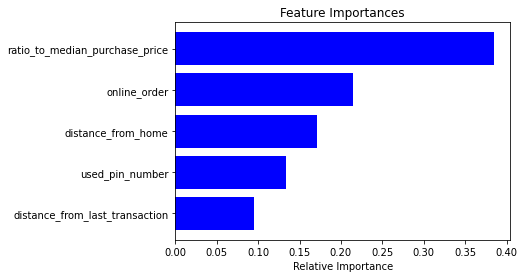

In [ ]:
features = X_train.columns
importances = xgb_clf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Neural Network

In [ ]:
def nn_model():
  model = Sequential()
  model.add(Dense(250, activation = 'relu', input_shape = (5 ,)))
  model.add(Dense(100, activation = 'relu'))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
  return model

In [ ]:
early_stopping_monitor = EarlyStopping(patience = 2)
nn_model = nn_model()
nn_model.fit(X_train, y_train, validation_split=0.3, epochs = 30,\
             callbacks=[early_stopping_monitor])
y_pred_proba = nn_model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

Epoch 1/30
16407/16407 [==============================] - 62s 4ms/step - loss: 0.0755 - accuracy: 0.9722 - val_loss: 0.0513 - val_accuracy: 0.9752
Epoch 2/30
16407/16407 [==============================] - 51s 3ms/step - loss: 0.0412 - accuracy: 0.9800 - val_loss: 0.0358 - val_accuracy: 0.9820
Epoch 3/30
16407/16407 [==============================] - 50s 3ms/step - loss: 0.0389 - accuracy: 0.9809 - val_loss: 0.0602 - val_accuracy: 0.9706
Epoch 4/30
16407/16407 [==============================] - 48s 3ms/step - loss: 0.0376 - accuracy: 0.9815 - val_loss: 0.0329 - val_accuracy: 0.9838
Epoch 5/30
16407/16407 [==============================] - 49s 3ms/step - loss: 0.0362 - accuracy: 0.9821 - val_loss: 0.0347 - val_accuracy: 0.9821
Epoch 6/30
16407/16407 [==============================] - 50s 3ms/step - loss: 0.0360 - accuracy: 0.9824 - val_loss: 0.0331 - val_accuracy: 0.9842


In [ ]:
y_pred_proba = nn_model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

In [ ]:
table = append_metrics_to_table(table, 'Nerual Network', y_pred, y_test)

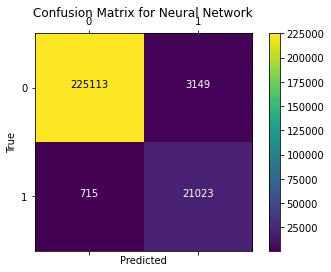

In [ ]:
plot_confusion_matrix(y_test, y_pred, title='Confusion Matrix for Neural Network', labels=[0,1])

In [ ]:
# Display dataframe comparison of all metrics
table

,Model,Accuracy,AUROC,Precision,Recall
0,Logreg without preproc,0.956212,0.918922,0.577560,0.876807
1,Decision Tree,0.939416,0.801751,0.741283,0.628569
2,RandomForestClassifier,0.985120,0.940172,0.952848,0.884868
3,XGBoost Classifier,0.986904,0.934777,0.999172,0.869635
4,Nerual Network,0.984544,0.933280,0.967108,0.869725


References:<br>
1) https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
